In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(5)

# Executing

In [2]:
class execute():
    def __init__(self, bandit, agents, case = 1000, runs = 2000):
        self.bandit = bandit
        self.agents = agents
        self.case = case
        self.runs = runs
        self.colors = ['green', 'yellow', 'red', 'black', 'blue']
        self.x_axis = np.zeros((len(agents), case, runs))
        self.y_axis = np.zeros((len(agents), case, runs))
        
    def start(self):
        for r in tqdm(range(self.runs)):
            for c in range(self.case):
                for a in range(len(self.agents)):
                    action = self.agents[a].action_selection()
                    reward = self.bandit.reward_function(action)
                    self.agents[a].update_function(action,reward)
                    self.x_axis[a][c][r] = self.x_axis[a][c][r] + reward
                    if self.bandit.optimal_action == action:
                        self.y_axis[a][c][r] = self.y_axis[a][c][r] + 1
            self.bandit.update()
            for a in range(len(agents)):
                self.agents[a].refresh()


# Plotting

In [3]:
def plotResults(sample):
    rewardMean = np.mean(sample.x_axis, axis=2)
    optimalityMean = np.mean(sample.y_axis, axis=2)
    time = np.array(list(range(sample.case)))

    for a in range(len(sample.agents)):
        plt.subplot(2, 1, 1)
        plt.plot(time, optimalityMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('% Optimal Action')

        plt.subplot(2, 1, 2)
        plt.plot(time, rewardMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('Average Reward')
        plt.xlabel('play')

    plt.legend(loc='best', fancybox=True)
    plt.show()

# K-Bandit Environment

In [4]:
#env=0 : stationary environment
#env=1 : non stationary environment

class bandit():
    def __init__(self,env=0, k=10, mean=0, std_dev=1, randomWalk=0.01):
        self.k = k
        self.mean = mean
        self.std_dev = std_dev
        self.randomWalk = randomWalk
        self.env = env    
        self.bandits = np.arange(k)
        if self.env == 0:
            self.q_star = np.random.normal(mean, std_dev, k)    #q* having k points with values with mean 0 and std deviation 1
            value = max(self.q_star)
            self.optimal_action = np.random.choice(np.flatnonzero(self.q_star == value))
        else:
            self.q_star = np.zeros(k)    #q* having k points with vlaues i/k (equal rewards)
            self.q_star.fill(1/k)
            value = 1/k
            self.optimal_action = np.random.choice(np.flatnonzero(self.q_star == value))
        
    def reward_function(self, selected_action):
        if self.env==0:
            return np.random.normal(self.q_star[selected_action],scale=1)
        else:
            self.q_star = self.q_star + np.random.normal(0, scale=self.randomWalk, size = self.k)
            value = max(self.q_star)
            self.optimal_action = np.random.choice(np.flatnonzero(self.q_star == value))
            return np.random.normal(self.q_star[selected_action],scale=1)
    
    def update(self):
        if self.env==0:
            self.q_star = np.random.normal(self.mean, self.std_dev, self.k)
            value = max(self.q_star)
            self.optimal_action = np.random.choice(np.flatnonzero(self.q_star == value))
        else:
            self.q_star.fill(1/self.k)
            value = 1/self.k
            self.optimal_action = np.random.choice(np.flatnonzero(self.q_star == value))

# Implementation of Different Algorithms

In [6]:
#algo=0 : epsilon greedy
#algo=1 : optimistic initial value
#algo=2 : UCB

class Algo():
    def __init__(self, algo, k, epsilon=0.1, alpha=0, Q_initial=5, c=2):
        self.algo = algo
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        if self.algo==1:
            self.Q_initial = Q_initial
        if self.algo==2:
            self.c = c
        self.k_choice = np.arange(k)
        self.Q = np.zeros(k)    #initializing Q values with 0
        if self.algo==1:
            self.Q.fill(self.Q_initial)
        if self.alpha==0:
            self.action_count = np.zeros(k)    #initializing count of each action with 0
        if self.algo==2:
            self.action_count = np.zeros(k)
            self.time = 0
        
    def action_selection(self):
        if self.algo==2:
            self.time = self.time+1
            ucb = self.Q + self.c*np.sqrt(np.log(self.time)/self.action_count)
            return np.argmax(ucb)
        else:
            #exploitation
            if np.random.rand() > self.epsilon:
                value = max(self.Q)
                return np.random.choice(np.flatnonzero(self.Q == value))
            #exploration
            else:
                return np.random.choice(self.k_choice)
        
    def update_function(self,i,reward):
        #Sample Average Method
        if self.alpha==0 or self.algo==2:
            self.action_count[i] = self.action_count[i]+1
            curr_q = self.Q[i]
            #step size = 1/count of that particular action
            self.Q[i] = curr_q + ((1/self.action_count[i]) * (reward-curr_q))
        #Constant step size alpha
        else:
            curr_q = self.Q[i]
            #step size = alpha
            self.Q[i] = curr_q + (self.alpha * (reward-curr_q))
        
    def __repr__(self):
        if self.algo==0:
            if self.alpha==0:
                return "Epsilon= "+str(self.epsilon)
            else:
                return "Epsilon= " + str(self.epsilon) + " Alpha=  " + str(self.alpha)
        elif self.algo==1:
            return "Optimistic " + (("Epsilon= " + str(self.epsilon)) if self.epsilon > 0 else "Greedy")
        elif self.algo==2:
            return "UCB: " + str(self.c)
    
    def refresh(self):
        if self.algo==1:
            self.Q.fill(self.Q_initial)
        else:
            self.Q.fill(0)
            if self.alpha==0:
                self.action_count.fill(0)
            if self.algo==2:
                self.action_count.fill(0)
                self.time = 0

# Ex: 2.5

In [8]:
stat = bandit(0)
nstat = bandit(1)

agents = [Algo(0,stat.k, 0.1), Algo(0,stat.k, 0.1, 0.1)]
sample = execute(nstat, agents, case = 10000) 
sample.start()

100%|██████████| 2000/2000 [19:55<00:00,  1.70it/s]


C:\Users\anuparna\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


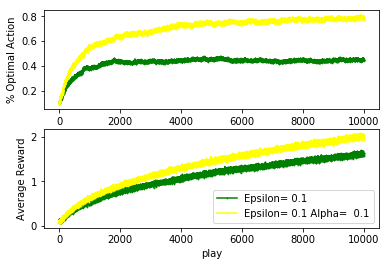

In [9]:
plotResults(sample)

# Ex: 2.6

100%|██████████| 2000/2000 [01:09<00:00, 28.61it/s]


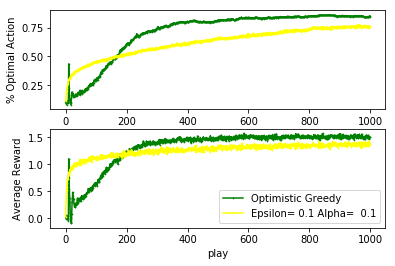

In [10]:
#Stationary Environment
agents = [Algo(1,stat.k, 0), Algo(0,stat.k, 0.1, 0.1)]
sample_stat = execute(stat, agents)
sample_stat.start()
plotResults(sample_stat)

100%|██████████| 2000/2000 [02:07<00:00, 14.72it/s]


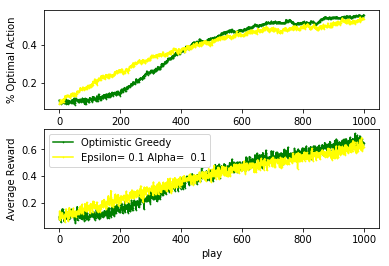

In [11]:
#Non Stationary Environment
agents = [Algo(1,nstat.k, 0), Algo(0,nstat.k, 0.1, 0.1)]
sample_nstat = execute(nstat, agents)
sample_nstat.start()
plotResults(sample_nstat)

# Question: 4

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 2000/2000 [02:34<00:00, 12.92it/s]


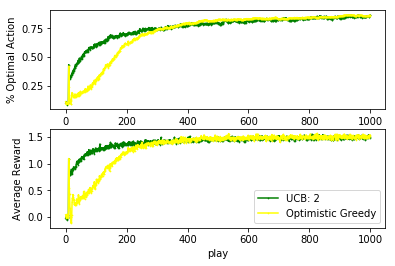

In [15]:
#UCB vs optimistic value in stationary environment
agents = [Algo(2,stat.k,0,0,0, 2), Algo(1,stat.k, 0)]
sample_ucb_stat = execute(stat, agents)
sample_ucb_stat.start()
plotResults(sample_ucb_stat)

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 2000/2000 [04:52<00:00,  7.28it/s]


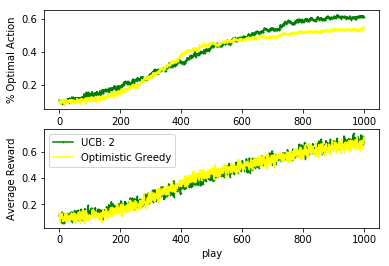

In [16]:
#UCB vs optimistic value in non stationary environment
agents = [Algo(2,nstat.k,0,0,0, 2), Algo(1,nstat.k, 0)]
sample_ucb_nstat = execute(nstat, agents)
sample_ucb_nstat.start()
plotResults(sample_ucb_nstat)

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 2000/2000 [02:25<00:00, 13.73it/s]


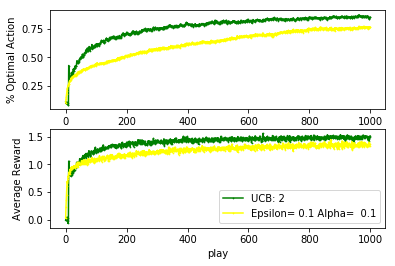

In [17]:
#UCB vs e-greedy in stationary environment
agents = [Algo(2,stat.k,0,0,0,2), Algo(0,stat.k, 0.1, 0.1)]
sample_ucb_stat1 = execute(stat, agents)
sample_ucb_stat1.start()
plotResults(sample_ucb_stat1)

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\anuparna\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 2000/2000 [04:53<00:00,  7.18it/s]


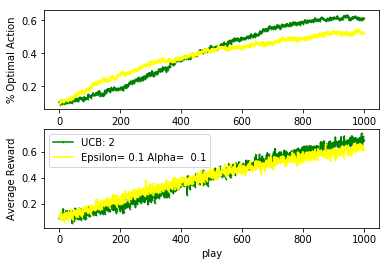

In [18]:
#UCB vs e-greedy in non stationary environment
agents = [Algo(2,nstat.k,0,0,0,2), Algo(0,nstat.k, 0.1, 0.1)]
sample_ucb_nstat1 = execute(nstat, agents)
sample_ucb_nstat1.start()
plotResults(sample_ucb_nstat1)